<a href="https://colab.research.google.com/github/lakigigar/BitsofDNA/blob/master/Reply_to_Sun_et_al/FDR_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

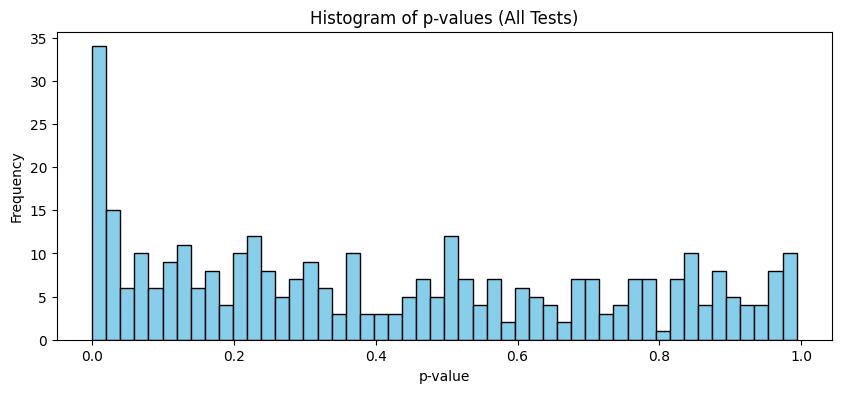

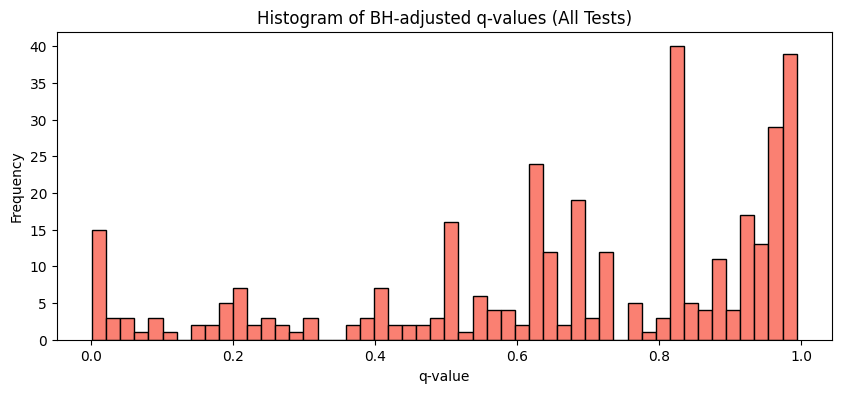

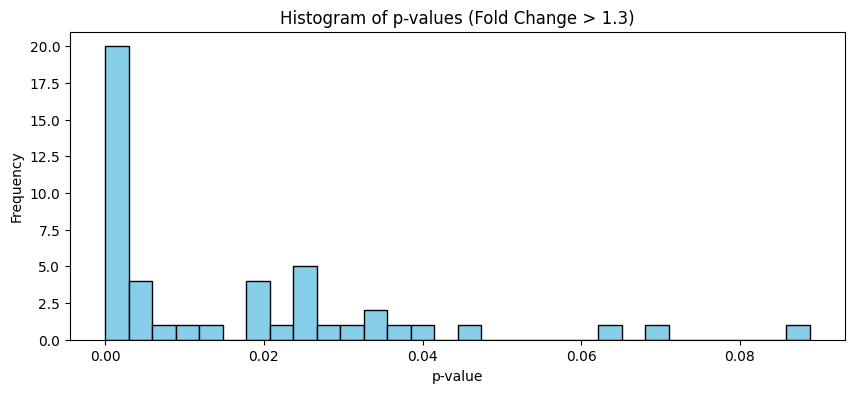

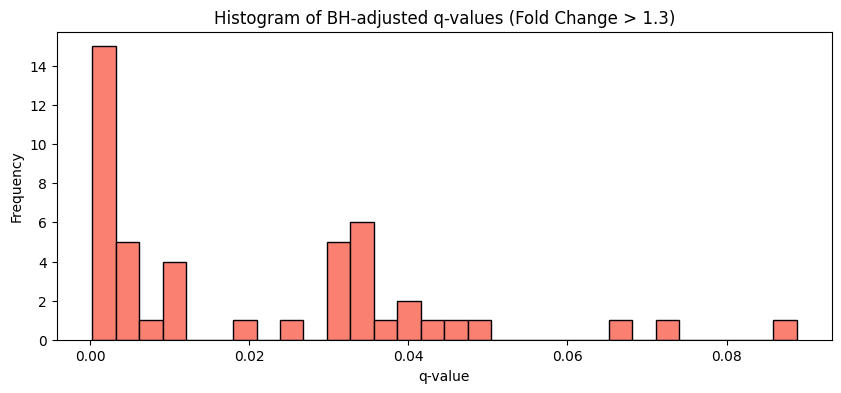

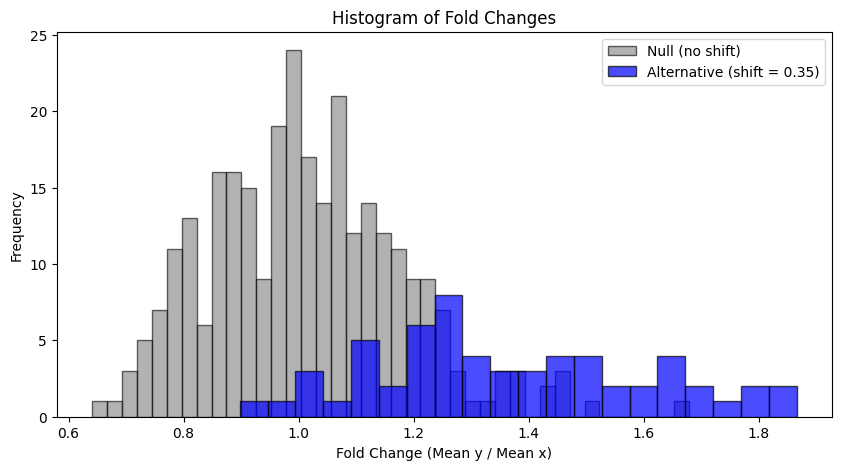

                                 Metric  Value
                            Total Tests 350.00
                True Effects (non-null)  60.00
                  Fold Change Threshold   1.30
         Nominal Discoveries (p < 0.05)  53.00
               True Positives (Nominal)  34.00
              False Positives (Nominal)  19.00
              False Negatives (Nominal)  26.00
               True Negatives (Nominal) 271.00
         False Discovery Rate (Nominal)   0.36
             BH Discoveries (All Tests)  20.00
                    True Positives (BH)  19.00
                   False Positives (BH)   1.00
                   False Negatives (BH)  41.00
                    True Negatives (BH) 289.00
        Expected False Discoveries (BH)   1.00
              False Discovery Rate (BH)   0.05
                 Bonferroni Discoveries   6.00
                  True Positives (Bonf)   6.00
                 False Positives (Bonf)   0.00
                 False Negatives (Bonf)  54.00
             

In [ ]:
# This code illustrates some elementary aspects of multiple testing correction and the double dipping problem
# The code was written by Lior Pachter accelerated by chatGPT for the blog post:

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

np.random.seed(5114) # = 2*2557

# Parameters for the experiment
num_tests = 350
num_alternative = 60
sample_size = 85
shift = 0.35
fold_change_threshold = 1.3

p_values = []
fold_changes = []

# Simulation code
for i in range(num_tests):
    x = np.random.normal(1, 1, sample_size)
    if i < num_alternative:
        y = np.random.normal(1 + shift, 1, sample_size)
    else:
        y = np.random.normal(1, 1, sample_size)
    stat, p = ttest_ind(x, y)
    p_values.append(p)
    fc = np.mean(y) / np.mean(x)
    fold_changes.append(fc)

p_values = np.array(p_values)
fold_changes = np.array(fold_changes)

# Benjamini-Hochberg and Bonferroni corrections
rejected_bh, q_values_bh, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
rejected_bonf, p_values_bonf, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Nominal p-value statistics
rejected_nominal = p_values < 0.05
tp_nom = np.sum(rejected_nominal[:num_alternative])
fn_nom = num_alternative - tp_nom
fp_nom = np.sum(rejected_nominal[num_alternative:])
tn_nom = (num_tests - num_alternative) - fp_nom
n_nom = np.sum(rejected_nominal)
fdr_nom = fp_nom / n_nom if n_nom > 0 else 0

# BH statistics
tp_bh = np.sum(rejected_bh[:num_alternative])
fn_bh = num_alternative - tp_bh
fp_bh = np.sum(rejected_bh[num_alternative:])
tn_bh = (num_tests - num_alternative) - fp_bh
n_bh = np.sum(rejected_bh)
expected_fp_bh = 0.05 * n_bh
fdr_bh = fp_bh / n_bh if n_bh > 0 else 0

#  Bonferroni statistics
tp_bonf = np.sum(rejected_bonf[:num_alternative])
fn_bonf = num_alternative - tp_bonf
fp_bonf = np.sum(rejected_bonf[num_alternative:])
tn_bonf = (num_tests - num_alternative) - fp_bonf
n_bonf = np.sum(rejected_bonf)
expected_fp_bonf = 0.05 * n_bonf
fdr_bonf = fp_bonf / n_bonf if n_bonf > 0 else 0

#  PLOTS
plt.figure(figsize=(10, 4))
plt.hist(p_values, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of p-values (All Tests)')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(q_values_bh, bins=50, color='salmon', edgecolor='black')
plt.title('Histogram of BH-adjusted q-values (All Tests)')
plt.xlabel('q-value')
plt.ylabel('Frequency')
plt.show()

#  Fold change selection followed by Benjamini-Hochberg illustrating the results of double dipping
selected_indices = np.where(fold_changes > fold_change_threshold)[0]
top_p_values = p_values[selected_indices]
top_true_flags = selected_indices < num_alternative

if len(top_p_values) > 0:
    rejected_top, q_values_top, _, _ = multipletests(top_p_values, alpha=0.05, method='fdr_bh')
    n_top = np.sum(rejected_top)
    tp_top = np.sum(top_true_flags[rejected_top])
    fp_top = np.sum(~top_true_flags[rejected_top])
    discovered_true_indices_top = set(selected_indices[rejected_top]) & set(range(num_alternative))
    fn_top_global = num_alternative - len(discovered_true_indices_top)
    num_selected = len(selected_indices)
    true_in_top = np.sum(top_true_flags)
    tn_top = (num_selected - true_in_top) - fp_top
    expected_fp_top = 0.05 * n_top
    fdr_top = fp_top / n_top if n_top > 0 else 0
else:
    rejected_top = np.array([])
    q_values_top = np.array([])
    n_top = 0
    tp_top = 0
    fp_top = 0
    fn_top_global = num_alternative
    num_selected = 0
    true_in_top = 0
    tn_top = 0
    expected_fp_top = 0
    fdr_top = 0

#  More PLOTS
if len(top_p_values) > 0:
    plt.figure(figsize=(10, 4))
    plt.hist(top_p_values, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of p-values (Fold Change > {fold_change_threshold})')
    plt.xlabel('p-value')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.hist(q_values_top, bins=30, color='salmon', edgecolor='black')
    plt.title(f'Histogram of BH-adjusted q-values (Fold Change > {fold_change_threshold})')
    plt.xlabel('q-value')
    plt.ylabel('Frequency')
    plt.show()

null_fc = fold_changes[num_alternative:]
alt_fc = fold_changes[:num_alternative]

plt.figure(figsize=(10, 5))
plt.hist(null_fc, bins=40, alpha=0.6, label='Null (no shift)', color='gray', edgecolor='black')
plt.hist(alt_fc, bins=20, alpha=0.7, label='Alternative (shift = {:.2f})'.format(shift), color='blue', edgecolor='black')
plt.title('Histogram of Fold Changes')
plt.xlabel('Fold Change (Mean y / Mean x)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#  Summary Results
results = pd.DataFrame({
    'Metric': [
        'Total Tests',
        'True Effects (non-null)',
        'Fold Change Threshold',
        'Nominal Discoveries (p < 0.05)',
        'True Positives (Nominal)',
        'False Positives (Nominal)',
        'False Negatives (Nominal)',
        'True Negatives (Nominal)',
        'False Discovery Rate (Nominal)',
        'BH Discoveries (All Tests)',
        'True Positives (BH)',
        'False Positives (BH)',
        'False Negatives (BH)',
        'True Negatives (BH)',
        'Expected False Discoveries (BH)',
        'False Discovery Rate (BH)',
        'Bonferroni Discoveries',
        'True Positives (Bonf)',
        'False Positives (Bonf)',
        'False Negatives (Bonf)',
        'True Negatives (Bonf)',
        'Expected False Discoveries (Bonf)',
        'False Discovery Rate (Bonf)',
        'Selected for FC > threshold',
        'BH Discoveries (Selected)',
        'True Positives (Selected)',
        'False Positives (Selected)',
        'False Negatives (Global, from Selected)',
        'True Negatives (Selected subset only)',
        'Expected False Discoveries (Selected)',
        'False Discovery Rate (Selected)'
    ],
    'Value': [
        num_tests,
        num_alternative,
        fold_change_threshold,
        n_nom,
        tp_nom,
        fp_nom,
        fn_nom,
        tn_nom,
        fdr_nom,
        n_bh,
        tp_bh,
        fp_bh,
        fn_bh,
        tn_bh,
        expected_fp_bh,
        fdr_bh,
        n_bonf,
        tp_bonf,
        fp_bonf,
        fn_bonf,
        tn_bonf,
        expected_fp_bonf,
        fdr_bonf,
        num_selected,
        n_top,
        tp_top,
        fp_top,
        fn_top_global,
        tn_top,
        expected_fp_top,
        fdr_top
    ]
})

print(results.round(2).to_string(index=False))
